# Image Gradients
이번 노트북 에서는  
 - TinyImageNet 데이터 셋을 알려준다.  
 - 해당 데이터 셋에 대해 기훈련된(pretrained) deep CNN 도 알려준다.  
 - 어떤 이미지에 대한 미분값을 구하기위해 이 deep CNN 모델을 사용할 수 있다. 
 - 이미지 미분값을 구해서 특징 맵(saliency maps) 과  fooling images 들을 만들 수 있다.

In [52]:
%%javascript
var fname = document.body.attributes['data-notebook-name'].value
var fpath = document.body.attributes['data-notebook-path'].value.replace(/^local/, '/root').replace(fname, '')
IPython.notebook.kernel.execute("theNoteBookDir = '" + fpath + "'" );

<IPython.core.display.Javascript object>

In [53]:
import os
os.chdir(theNoteBookDir)

In [54]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils                 import load_tiny_imagenet
from cs231n.image_utils                import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize']      = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap']          = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TinyImageNet


TinyImageNet 데이터셋은 ILSVRC-2012 분류 데이터셋의 부분 집합 이다.

- 클래스는 총 200 개이다. 각 클래스마다  
  500 개의 훈련 이미지, 50개의 검증(validation)이미지, 50개의 테스트 이미지가 있다.  
- 모든 이미지는 64x64 픽셀로 줄여져 있다.
- 훈련이미지와 검증 이미지는 라벨링이 되어 있고  
  테스트 이미지는 라벨링이 없다.    
- 전체  TinyImageNet dataset 을 
  각 조각의 클래스 갯수가 100 개의 클래스가 되도록  
  같은 크기의 두 조각으로 나눠서.  
  각각을 TinyImageNet-100-A, TinyImageNet-100-B 라 부른다. 
- 이번 연습문제에서는 TinyImageNet-100-A만 사용한다.
- 데이터 다운로드 방법
   - `cs231n/datasets` 디렉토리에 가서  `get_tiny_imagenet_a.sh` 를 실행시킨다. (<-- 이러지 않아도 됨 . 이미 있음)
   - 위 스크립트를 실행시키면 TinyImageNet-100-A 데이터셋을 메모리로 로드할 것이다.
   
- Note: TinyImageNet-100-A 데이터셋 전체는  
   - 약 250MB 의 디스크 공간을 차지한다.  
   - 메모리로 로드하게 되면 약 2.8GB가 될 것이다.

In [55]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


# TinyImageNet-100-A classes
이미지넷은 - WorNet 에 기반하고 있기 때문에 -동일 클래스가 다른 이름을 가지는 경우도 있다.  
예를 들면  "pop bottle" 과 "soda bottle" 은 같은 클래스에 대한 다른 이름이다.  
아래 셀을 실행하면 TinyImageNet-100-A: 데이터의 모든 클래스에 대한 이름을 볼 수 있다.

In [57]:
for i, names in enumerate(data['class_names']):
    print i, ' '.join('"%s"' % name for name in names)

0 "Egyptian cat"
1 "reel"
2 "volleyball"
3 "rocking chair" "rocker"
4 "lemon"
5 "bullfrog" "Rana catesbeiana"
6 "basketball"
7 "cliff" "drop" "drop-off"
8 "espresso"
9 "plunger" "plumber's helper"
10 "parking meter"
11 "German shepherd" "German shepherd dog" "German police dog" "alsatian"
12 "dining table" "board"
13 "monarch" "monarch butterfly" "milkweed butterfly" "Danaus plexippus"
14 "brown bear" "bruin" "Ursus arctos"
15 "school bus"
16 "pizza" "pizza pie"
17 "guinea pig" "Cavia cobaya"
18 "umbrella"
19 "organ" "pipe organ"
20 "oboe" "hautboy" "hautbois"
21 "maypole"
22 "goldfish" "Carassius auratus"
23 "potpie"
24 "hourglass"
25 "seashore" "coast" "seacoast" "sea-coast"
26 "computer keyboard" "keypad"
27 "Arabian camel" "dromedary" "Camelus dromedarius"
28 "ice cream" "icecream"
29 "nail"
30 "space heater"
31 "cardigan"
32 "baboon"
33 "snail"
34 "coral reef"
35 "albatross" "mollymawk"
36 "spider web" "spider's web"
37 "sea cucumber" "holothurian"
38 "backpack" "back pack" "knaps

# 시각화 예제
TinyImageNet-100-A 의 임의 클래스에서 예제 몇개를 골라서 시각화 하자.  
클래스와 이미지를 임의로 고르기 때문에 실행시킬 때 마다 다른 그림을 볼 수 있다.

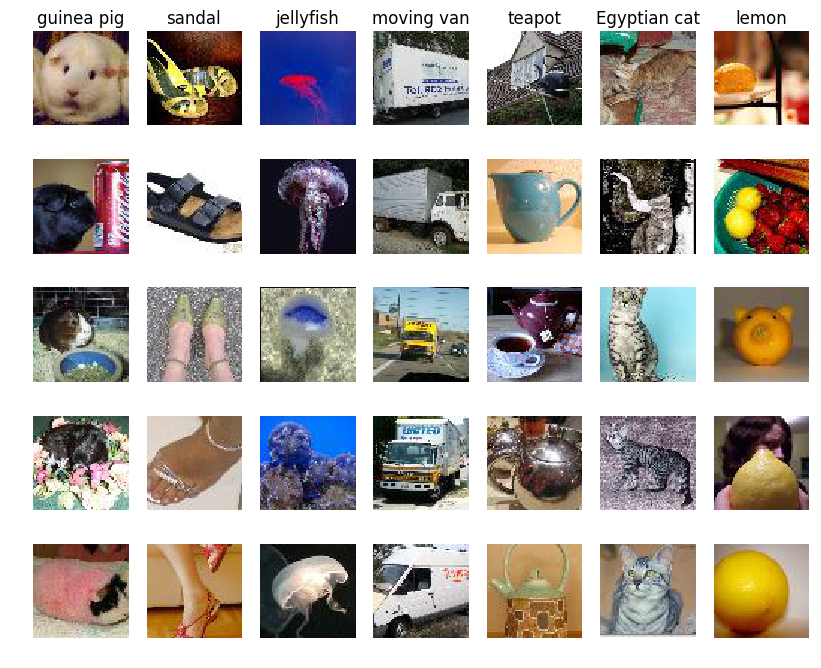

In [58]:
# 훈련 데이터 몇 개 시각화 하기
classes_to_show    = 7
examples_per_class = 5

class_idxs = np.random.choice(len(data['class_names']), size=classes_to_show, replace=False)
for i, class_idx in enumerate(class_idxs):
    train_idxs, = np.nonzero(data['y_train'] == class_idx)
    train_idxs  = np.random.choice(train_idxs, size=examples_per_class, replace=False)
    for j, train_idx in enumerate(train_idxs):
        img = deprocess_image(data['X_train'][train_idx], data['mean_image'])
        plt.subplot(examples_per_class, classes_to_show, 1 + i + classes_to_show * j)
        if j == 0:
            plt.title(data['class_names'][class_idx][0])
        plt.imshow(img)
        plt.gca().axis('off')

plt.show()

# 기 학습된(Pretrained) model

cs231 수업에서는 TinyImageNet-100-A 데이터 셋에 대해 이미 학습이 된 deep CNN을 제공한다.
- 이 모델은 
  - 이미지 시각화에 사용될 것이다.
  - 9 개의 컨볼루션 레이어를 가진다.
     - 컨볼루션 레이어에는 spatial batch normalization을 넣는다
  - 1개의 FC (fully-connected) 은닉 레이어를 갖는다.
     - FC 레이어에는 배치 노말라이즈를 넣는다.

모델을 다운받기 위해서는 `cs231n/datasets` directory 폴더에서 `get_pretrained_model.sh` 를 수행하라. (<-- 이러지 않아도 됨 . 이미 있음)  
다운 받은 디스크의 모델을 메모리로 올리기 위해서는 아래 셀을 실행시키면 된다

In [60]:
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

## 기 학습된 모델의 성능
아래 셀은 임의의 훈련 셋과 검증 셋에 대해 해당 모델의 성능을 테스트 한다.  
훈련 정확도는 약 90%, 검증 정확도는 약 60% 정도를 보게 될 것이다.   
(  <--훈련 정확도가 85% 근처, 또는 검증 정확도가 55% 근처일 때도 종종 있으니 놀라지 말 것)  
이 정확도 수치는 오버피팅 상태임을 알려지만   
우리의 시각화 실험에는 문제가 없을 것이다.

In [61]:
batch_size = 100

# 훈련 데이터에 대해 테스팅 한다.
mask   = np.random.randint(data['X_train'].shape[0], size=batch_size)
X, y   = data['X_train'][mask], data['y_train'][mask]
y_pred = model.loss(X).argmax(axis=1)
print 'Training accuracy: ', (y_pred == y).mean()

# 검증 데이터에 대해 테스팅 한다.
mask   = np.random.randint(data['X_val'].shape[0], size=batch_size)
X, y   = data['X_val'][mask], data['y_val'][mask]
y_pred = model.loss(X).argmax(axis=1)
print 'Validation accuracy: ', (y_pred == y).mean()

Training accuracy:  0.92
Validation accuracy:  0.69


# 특징 맵(Saliency Maps)
위의 기 훈련된 모델을 이용해서, 클래스 특징 맵을 계산할 것이다.   
클래스 특징 맵에 대한 설명은 논문[1] 의 3.1 섹션을 참고하라.  

이 논문의 섹션 2 에서 언급하듯이  
이미지 미분값은 정규화된 확률값이 아닌 정규화 되지 않은 점수에 대해 계산되어야 한다.  

`PretrainedCNN` 클래스의 `forward` 와 `backward` 맴버 함수를 이용해서 해당 이미지에 대한 미분값을 구할 수 있다.  


`cs231n/classifiers/pretrained_cnn.py` 파일의 문서 내용을 읽고 동작 방식을 이해하라.  
예를 들어 `loss`  맴버 함수의 경우 특징 맵을 계산할 때는 forward함수를  `test` 모드로 돌려야 한다.


논문 [1]:  
 Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman.  
"Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps",  
ICLR Workshop 2014.

cs231n 강의 슬라이드.  
![image](https://cloud.githubusercontent.com/assets/1628848/20587279/9fc0ccd4-b24f-11e6-8735-722e7aee85a0.png)
![image](https://cloud.githubusercontent.com/assets/1628848/20587300/c3cc1034-b24f-11e6-8598-ee31a0385b92.png)

In [66]:
def compute_saliency_maps(X, y, model):
    """
    이미지 X 와 라벨 y 에 대해 model 을 이용해 특징 맵을 계산하라.
  
    입력:
        - X (N, 3, H, W): 입력 이미지
        - y (N,)        : X에 대한 라벨
        - model         : PretrainedCNN. 특징 맵 계산에 사용됨.
    출력:
        - saliency (N, H, W) : 입력 이미지에 대응되는 특징 맵을 갖는 배열.
    """
    saliency = None
    ##############################################################################
    # 할일: 함수 구현하기.                                                       #
    # PretrainedCNN  클래스의 forward, backward 맴버 함수를 이용해서             #
    # 그라운드 트루쓰 y 의 정규화 되지 않은 클래스 스코어에 대한 미분값을        #
    # 계산하라.                                                                  #
    ##############################################################################
    N, _, H, W = X.shape
    
    # 1.1. Feed Image into net
    # 1.2.1 pick a layer (layer 10)
    out,  cache = model.forward(X)
    
    # 1.2.2 set the gradient there to be all zero
    dout = np.zeros_like(out)  # (5, 100)
        
    # 1.2.3  excpet for one 1 for some nueron of interest            
    dout[:, y] = 1
    
    # 1.3. Backprop to image
    dX, grads = model.backward(dout, cache)
    
    # 2.1 at each pixel take abs val
    abs_val = np.abs(dX)     # (5, 3, 64, 64)
    
    # 2.2 and max over channels
    saliency = np.max(abs_val, axis = 1) # (5, 64, 64)    
    
    ##############################################################################
    #                             여기까지 짜면 됨                               #
    ##############################################################################
    return saliency

위 함수를 다 구현했으면 아래 셀을 실행시켜서  
TinyImageNet-100-A 검증 세트의 특징맵을  몇몇 클래스에 대해 시각화 해 보라.  

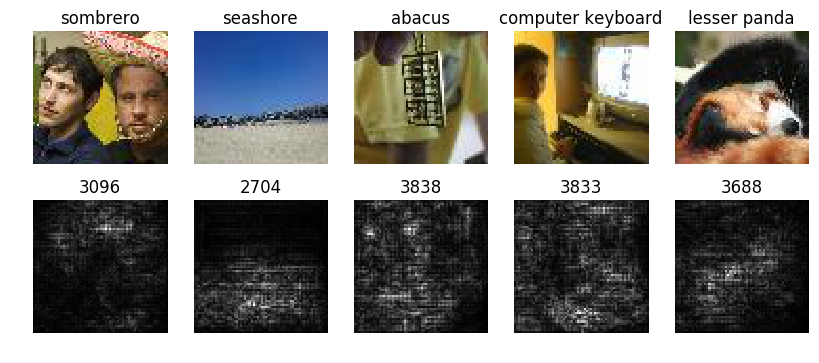

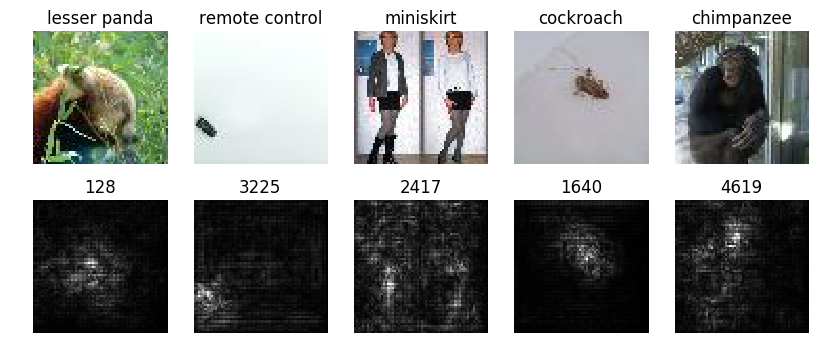

In [289]:
def show_saliency_maps(mask):
    mask = np.asarray(mask)
    X = data['X_val'][mask]
    y = data['y_val'][mask]

    saliency = compute_saliency_maps(X, y, model)

    for i in xrange(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(X[i], data['mean_image']))
        plt.axis('off')
        plt.title(data['class_names'][y[i]][0])
        plt.subplot(2, mask.size, mask.size + i + 1)
        plt.title(mask[i])
        plt.imshow(saliency[i])
        plt.axis('off')
    plt.gcf().set_size_inches(10, 4)
    plt.show()

# 몇몇 랜덤 이미지 보여주기
mask = np.random.randint(data['X_val'].shape[0], size=5)
show_saliency_maps(mask)
  
# 좋은 결과를 보여줘야 하는 몇 몇 이미지 고른 것.
show_saliency_maps([128, 3225, 2417, 1640, 4619])

# 거짓 이미지   Fooling Images
거짓 이미지를 만들기 위해 아래와 같이 이미지 미분값을 이용할 수 있다. 논문 [2] 참조

- 주어진 이미지와 타겟 클래스에 대해 
  - 해당 클래스 스코어 값을 최대화 하기 위해 gradient ascent 를 수행할 수 있다. 
  - 모델이 이미지를 타겟 클래스로 분류할 때 까지 gradient ascent 를 멈추면 된다.

논문 [2]:  
 Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

In [299]:
def make_fooling_image(X, target_y, model):
    """
    이미지 X와 유사한 거짓 이미지를 만든다.
    모델이 거짓 이미지X를 target_y 클래스로 분류하게 한다.
  
    입력:
        - X (1, 3, 64, 64): 입력 이미지
        - target_y        : [0, 100) 범위 안의 정수. 
        - model           :  PretrainedCNN
  
    출력:
        - X_fooling: 이미지 X와 유사한 거짓 이미지
                     model이 x_fooling 을  target_y 클래스로 분류해야 함.
    """
    X_fooling = X.copy()
    ##############################################################################
    # 할일: 거짓 이미지 X_fooling을 만든다.                                      #
    # model이 x_fooling 을  target_y 클래스로 분류해야 한다.                     #
    # gradient ascent 알고리즘을 model에 적용하라                                #
    # - 점수 계산을 위해서는 model.forward 함수를 사용하고                       #
    # - 이미지 미분값을 위해서는  model.backwrad 함수를 사용해라.                #
    #                                                                            #
    # 힌트: 대부분 예제에서 gradient ascent 알고리즘으로 거짓 이미지를 100 번    #
    #      이하로 생성하면 된다.                                                 #    
    ##############################################################################
    learning_rate = 100
    
    def make_fooling_image_sub(learning_rate, X_f, y):        
        for i in xrange(100):
            out,  cache = model.forward(X_f)             
            if out.argmax() == y:
                print 'success to make a fooling. learning_rate:', learning_rate, ', i:', i
                return True;
            dout       = np.zeros_like(out)        # (5, 100)
            dout[0, y] = 1
            dX,_       = model.backward(dout, cache)    
            X_f        += learning_rate*dX        
        return False
        
    lrs = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]    
    for lr in lrs:
        X_fooling = X.copy()
        print 'lr:', lr
        if make_fooling_image_sub(lr, X_fooling, target_y):
            break;
        
        
        
    ##############################################################################
    #                             여기까지 짜면 됨                               #
    ##############################################################################
    return X_fooling

Run the following to choose a random validation set image that is correctly classified by the network, and then make a fooling image.
아래 셀을 실행하라.


lr: 0.001
lr: 0.01
lr: 0.1
lr: 1
lr: 10
lr: 100
lr: 1000
success to make a fooling. learning_rate: 1000 , i: 50


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


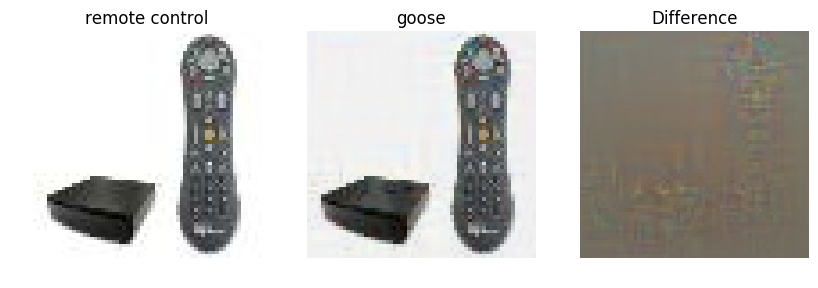

In [300]:
# Find a correctly classified validation image
while True:
    i      = np.random.randint(data['X_val'].shape[0])
    X      = data['X_val'][i:i+1]
    y      = data['y_val'][i:i+1]
    y_pred = model.loss(X)[0].argmax()
    if y_pred == y: break

target_y  = 67
X_fooling = make_fooling_image(X, target_y, model)

# Make sure that X_fooling is classified as y_target
scores = model.loss(X_fooling)
assert scores[0].argmax() == target_y, 'The network is not fooled!'

# Show original image, fooling image, and difference
plt.subplot(1, 3, 1)
plt.imshow(deprocess_image(X, data['mean_image']))
plt.axis('off')
plt.title(data['class_names'][y][0])
plt.subplot(1, 3, 2)
plt.imshow(deprocess_image(X_fooling, data['mean_image'], renorm=True))
plt.title(data['class_names'][target_y][0])
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Difference')
plt.imshow(deprocess_image(X - X_fooling, data['mean_image']))
plt.axis('off')
plt.show()